(60, 9)
0    0.994989
dtype: float64


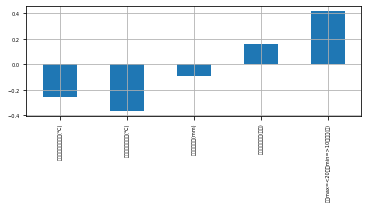

In [4]:
# -*- coding: utf-8 -*-
from sklearn.linear_model import Lasso,LassoCV,ElasticNet,ElasticNetCV
from sklearn.preprocessing import StandardScaler
import glob
import pandas as pd
import numpy as np
import copy
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import os
import json
import warnings
warnings.filterwarnings('ignore')
##############################
#lassoで機械的に変数を削除して、上位の変数を残す変数に追加してもう一度lassoをかける
##############################

class std_class():
    def __init__(self, data):
        self.data = data
    #データ標準化
    def std(self):
        data = self.data
        scaler = StandardScaler()
        scaler.fit(data.ix[:,1:])
        scaler.transform(data.ix[:,1:])
        data_std = pd.DataFrame(scaler.transform(data.ix[:,1:]), columns=data.ix[:,1:].columns)
        data_std = pd.concat([data.ix[:,[0]], data_std],axis=1)
        return data_std


def predict(model, data_path = "data/" ,file_name = "gunma_2019.csv"):
        data = pd.read_csv(data_path+file_name)
        #classを読み込む
        std_instance = std_class(data)
        data_std = std_instance.std()
        data_std = data
        pred = model.predict(data_std.ix[:,2:])
        pred = pd.DataFrame(pred)
        error = abs((data_std.ix[:,1] - pred.T) / data_std.ix[:,1])
        output = pd.concat([data_std.ix[:,1],pred,error.T], axis=1)
        output.to_csv("./output/predict.csv")
        print(error.T.mean())
    
'''
lassoで分析して、グラフの表示
'''

def main(data_path = "data/" ,file_name = "gunma.csv"):
    data = pd.read_csv(data_path+file_name)
    print(data.shape)
    #標準化
    #インスタンス生成
    std_instance = std_class(data)
    data_std = std_instance.std()
    #サンプリング
    X_train, X_test, Y_train, Y_test = train_test_split(data_std.ix[:,2:],data_std.ix[:,1], train_size=0.8,shuffle=False)
    #4年分と1年分をつなげて、最新８割をトレーニングデータに。時系列なのでshffle = false
    test_data = pd.concat([Y_test, X_test],axis = 1)
    #モデリング
    model = Lasso(alpha=0.005,normalize=False,random_state=0)
    model.fit(X_train , Y_train)
    #model = LogisticRegression(penalty ='l1')
    #model.fit(data_std.ix[:,1:] ,data_std.ix[:,0])
    #pandasでグラフ化のため、DF化
    coef = pd.DataFrame(model.coef_)
    coef.index = X_train.columns
    coef.to_csv("./output/coef.csv")
    coef = coef[coef[0] != 0]
    #棒グラフで凡例消すグリッド
    coef.plot(grid=True, kind='bar', legend=False, fontsize=5)
    #軸ラベルつける
    #plt.xticks(list(range(int(pd.DataFrame(X_train.ix[:,1:].columns).count()))),list(X_train.ix[:,1:].columns))
    #plt.xticks([0,1,2,3,4,5,6,7,8,9,10],list(data_std.ix[:,1:].columns))
    plt.subplots_adjust(bottom=0.5)
    plt.savefig(data_path+'../output/graph.png')
    predict(model = model)

if __name__ == '__main__':
    main()

